In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xgcm

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37279,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:44455,Total threads: 4
Dashboard: /proxy/46559/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41413,


In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_matt_RCP_humid_x.db'
session = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_RCPwarm_humid_x1', '1deg_jra55_ryf_RCPwarm_humid_x2']
name = ['RCPwarm_x1', 'RCPwarm_x2']

In [5]:
start_time = '2400-01-01'
end_time = '2499-12-31'

start_time_last = '2400-01-01'
end_time_last = end_time

ncoarse = 12

x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP']

Note: We do 'use_cftime = True' to prevent getting the warning:
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)

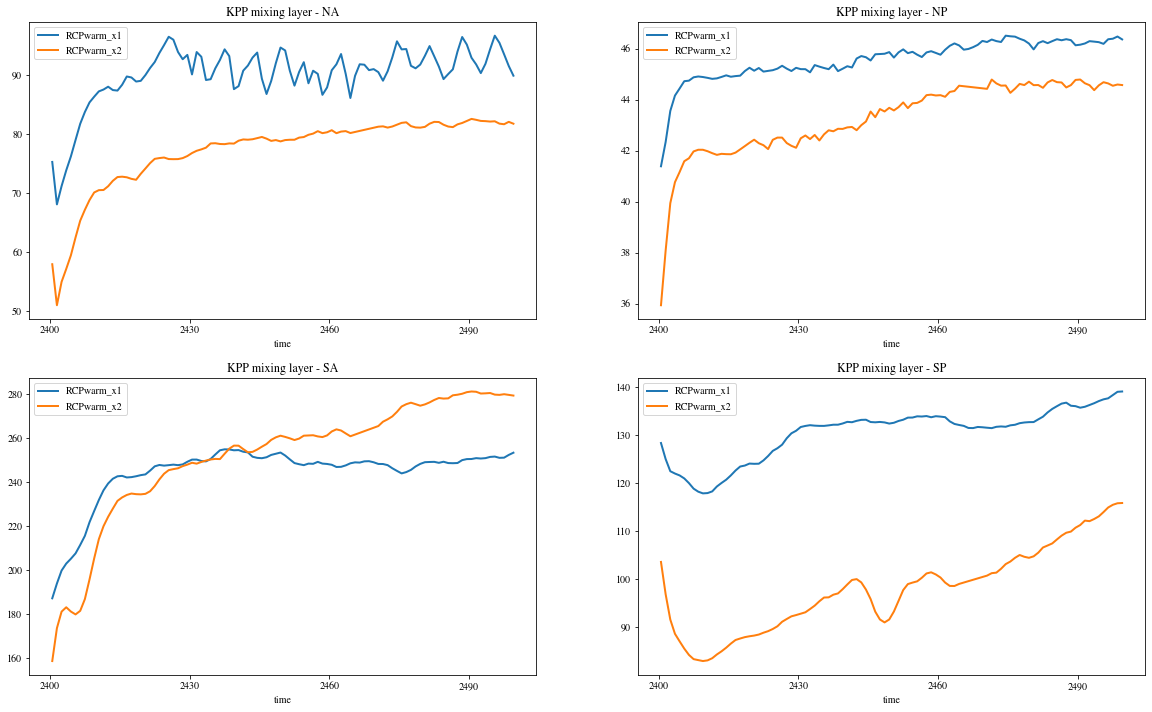

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(expt):
    hblt = cc.querying.getvar(expt = expt[i], session = session, variable = 'mld', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hblt)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = session, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hblt_basin = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hblt_basin = hblt_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hblt_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('KPP mixing layer - ' + basin[k])

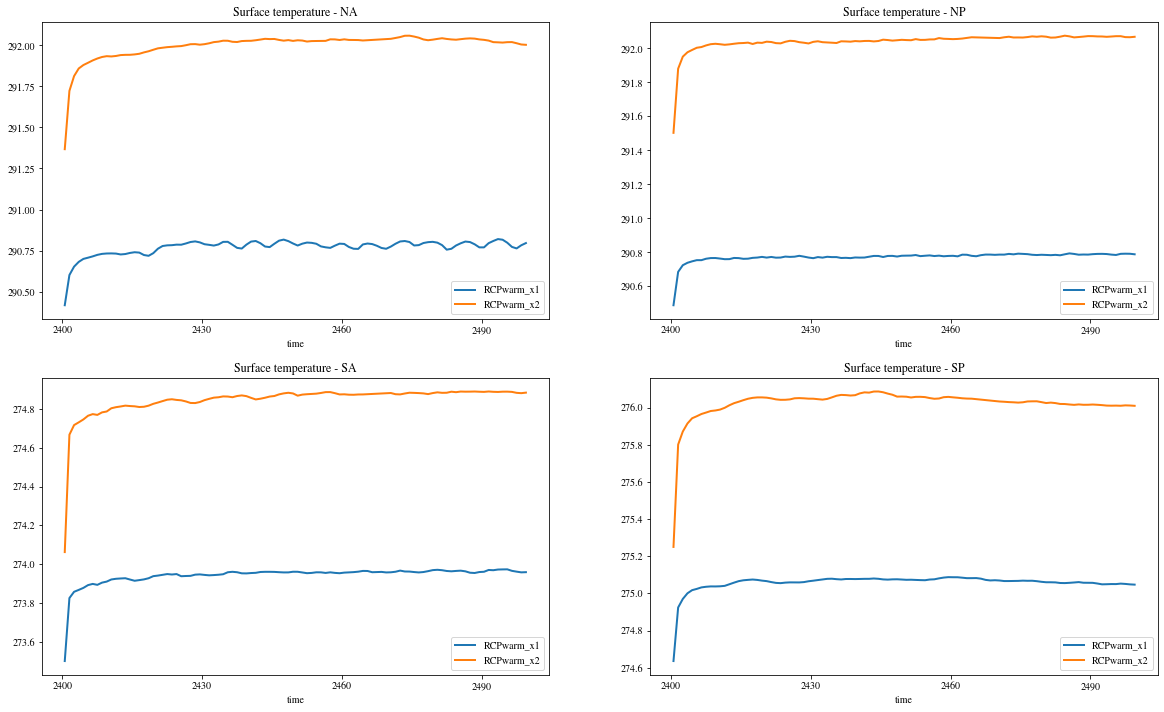

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(expt):
    
    temp_sfc = cc.querying.getvar(expt = expt[i], session = session, variable = 'temp', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time, end_time))
    temp_sfc = temp_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(temp_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = session, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        temp_sfc_basin = (temp_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        temp_sfc_basin = temp_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        temp_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface temperature - ' + basin[k])

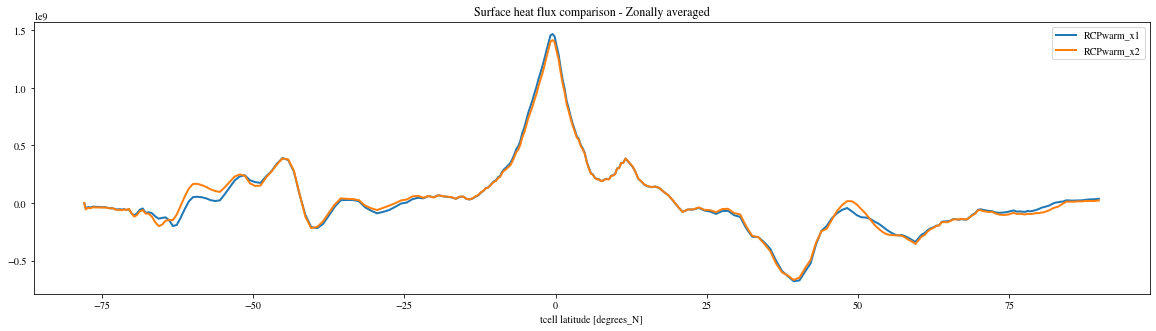

In [9]:
plt.figure(figsize = (20, 5))

var_list = ['swflx', 'lw_heat', 'evap_heat', 'sens_heat']
var_name = ['Shortwave', 'Longwave', 'Latent heat', 'Sensible heat']

start_time_heat = '2490-01-01'
end_time_heat = end_time

for i, j in enumerate(expt):
    sum_var = 0
    dxt = cc.querying.getvar(expt = expt[i], variable = 'dxt', session = session, frequency = 'static', n = 1)
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session, variable = l, frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time_heat, end_time_heat))
        variable = (variable * dxt).sum(dim = ['xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        sum_var = sum_var + variable
    sum_var.sel(time = slice(start_time_heat, end_time_heat)).mean('time').plot(label = name[i])
    plt.legend()
    plt.title('Surface heat flux comparison - Zonally averaged')

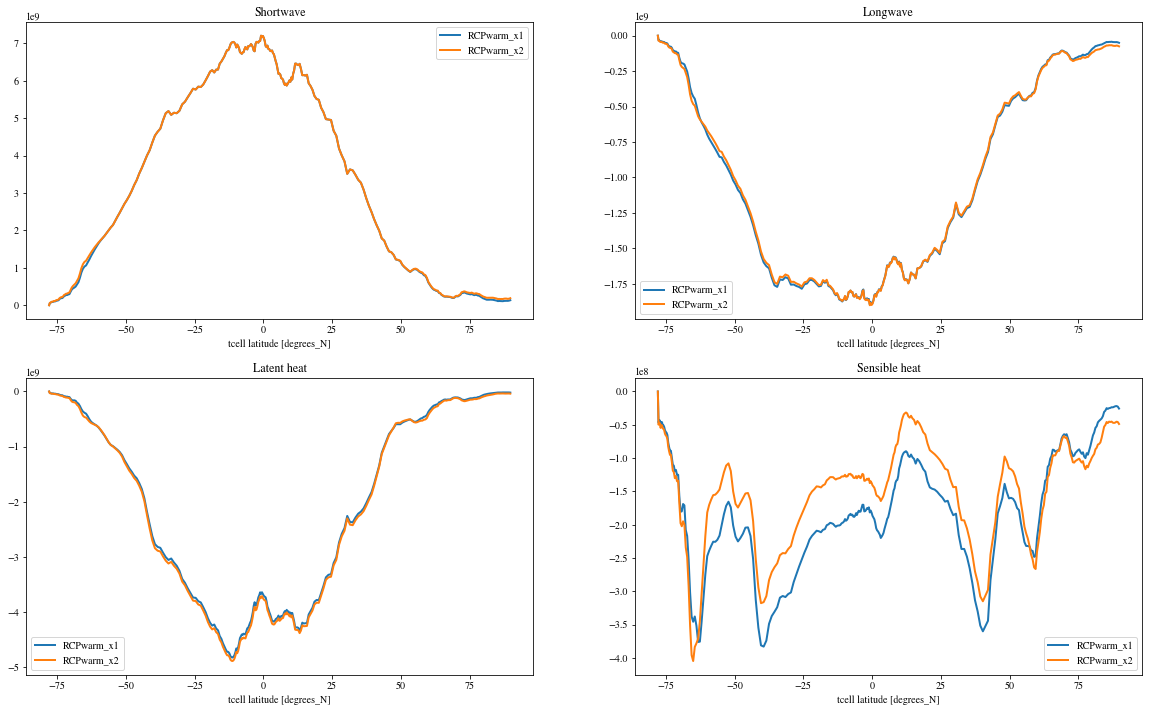

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(expt):
    dxt = cc.querying.getvar(expt = expt[i], variable = 'dxt', session = session, frequency = 'static', n = 1)
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session, variable = l, frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time, end_time))
        variable = (variable * dxt).sum(dim = ['xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        variable.sel(time = slice(start_time, end_time)).mean('time').plot(ax = axes[int(k/2)][int(k%2)], label = name[i])
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title(var_name[k])